In [1]:
import qiskit
import qc_grader

print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")


Qiskit version: 2.1.1
Grader version: 0.22.12


In [3]:
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout

from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_aer import AerSimulator

from utils import zne_method, plot_zne, plot_backend_errors_and_counts
from qc_grader.challenges.qgss_2025 import (
    grade_lab2_ex1,
    grade_lab2_ex2,
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5,
    grade_lab2_ex6a,
    grade_lab2_ex6b,
)

In [4]:
# Execute to make arrays of properties
service = QiskitRuntimeService(name="qgss-2025")
# We define a specific backend
brisbane_backend = service.backend("ibm_brisbane")
# We obtain the system properties, number of qubits and coupling map
properties = brisbane_backend.properties()
num_qubits = brisbane_backend.num_qubits
coupling_map = brisbane_backend.coupling_map

# We define various lists of metrics for all the qubits of the backend
t1, t2, gate_error_x, readout_error, gate_error_ecr = [], [], [], [], []
for i in range(num_qubits):
    t1.append(properties.t1(i))
    t2.append(properties.t2(i))
    gate_error_x.append(properties.gate_error(gate="x", qubits=i))
    readout_error.append(properties.readout_error(i))
for pair in coupling_map:
    gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService

def find_best_metrics(backend) -> list[list]:
    """Finds the best-performing qubits and qubit pair based on various hardware metrics."""
    
    # ---- TODO : Task 0 ---
    # Define metrics lists for the backend
    properties = backend.properties()
    num_qubits = backend.num_qubits
    coupling_map = backend.coupling_map
    
    t1, t2, gate_error_x, readout_error, gate_error_ecr = [], [], [], [], []
    for i in range(num_qubits):
        t1.append(properties.t1(i))
        t2.append(properties.t2(i))
        gate_error_x.append(properties.gate_error(gate="x", qubits=[i]))
        readout_error.append(properties.readout_error(i))
    for pair in coupling_map:
        gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))
    # --- End of TODO ---
    
    # ---- TODO : Task 1 ---
    # Goal: Obtain the best value and the index or indices of the qubits of the following metrics:

    # Find the best qubit (index_t1_max) with the longest T1 and its value (max_t1)
    index_t1_max = t1.index(max(t1))
    max_t1 = max(t1)

    # Find the best qubit (index_t2_max) with the longest T2 and its value (max_t2)
    index_t2_max = t2.index(max(t2))
    max_t2 = max(t2)

    # Find the best qubit (index_min_x_error) with the smallest x gate error and its value (min_x_error)
    index_min_x_error = gate_error_x.index(min(gate_error_x))
    min_x_error = min(gate_error_x)

    # Find the best qubit (index_min_readout) with the smallest readout error and its value (min_readout)
    index_min_readout = readout_error.index(min(readout_error))
    min_readout = min(readout_error)

    # Find the best qubit pairs with minimum ecr error (min_ecr_pair) and its value (min_ecr_error)
    min_ecr_error = min(gate_error_ecr)
    # Fix: Convert coupling_map to a list to make it subscriptable
    coupling_map_list = list(coupling_map)
    min_ecr_index = gate_error_ecr.index(min_ecr_error)
    min_ecr_pair = coupling_map_list[min_ecr_index]
    
    # --- End of TODO ---

    solutions = [
        [int(index_t1_max), max_t1],
        [int(index_t2_max), max_t2],
        [int(index_min_x_error), min_x_error],
        [int(index_min_readout), min_readout],
        [list(min_ecr_pair), min_ecr_error],
    ]
    return solutions

In [11]:
grade_lab2_ex1(find_best_metrics)


Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


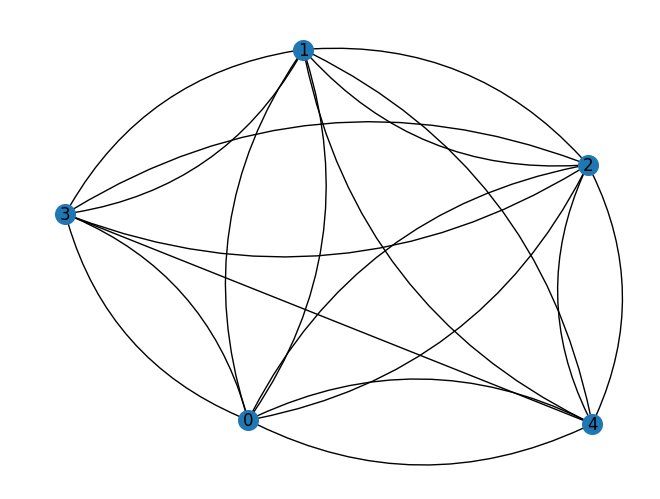

In [12]:
# We define the seed
seed = 43
# We define the number of nodes:
n = 5
# We define the graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
generic_backend = GenericBackendV2(n, seed=seed)
weights = 1
# We make it explicitly asymmetrical to have a smaller set of solutions
graph.add_edges_from([(edge[0], edge[1], weights) for edge in generic_backend.coupling_map][:-1])
draw_graph(graph, node_size=200, with_labels=True, width=1)


In [24]:
import rustworkx as rx
from qiskit.quantum_info import SparsePauliOp
import numpy as np

def graph_to_Pauli(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list."""
    pauli_list = []

    # ---- TODO : Task 2 ---
    # Goal: Convert the graph into a list like: [['PauliWord_1', weight_1], ['PauliWord_2', weight_2],...]
    
    n = graph.num_nodes()
    
    # For each edge in the graph, create a Z_i Z_j term
    for u, v, wt in graph.weighted_edge_list():
        # Create Pauli string: Z on positions u and v, I elsewhere
        pauli_string = ["I"] * n
        pauli_string[u] = "Z"
        pauli_string[v] = "Z"
        
        # Reverse for Qiskit's little-endian convention (qubit 0 is rightmost)
        pauli_word = "".join(reversed(pauli_string))
        
        # Add term with coefficient equal to edge weight
        pauli_list.append((pauli_word, float(wt)))
    
    # --- End of TODO ---

    return pauli_list

# Generate the Hamiltonian
max_cut_paulis = graph_to_Pauli(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

# Submit your answer using the following code
grade_lab2_ex2(graph_to_Pauli)


Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZZI', 'IZZII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j])
Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [25]:
real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")


The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


In [26]:
real_backends = [
    service.backend("ibm_brisbane"),
    service.backend("ibm_sherbrooke"),
    service.backend("ibm_torino"),
]

In [27]:
noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")


The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['reset', 'ecr', 'sx', 'id', 'x', 'measure']>), AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['reset', 'ecr', 'sx', 'id', 'x', 'measure']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['reset', 'sx', 'id', 'x', 'measure', 'cz']>)]


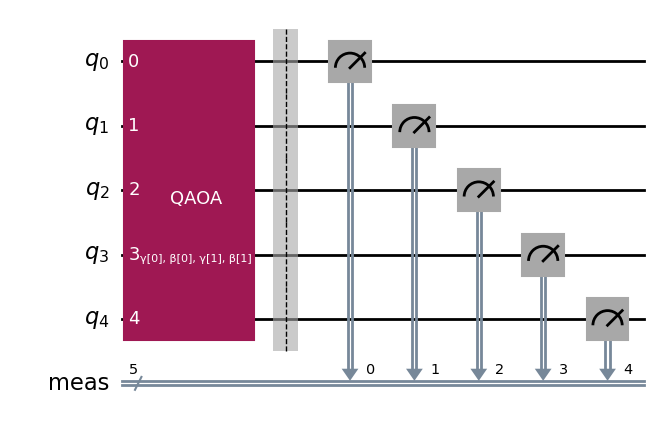

In [37]:
layers = 2
qaoa_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
qaoa_circuit.measure_all()
qaoa_circuit.draw("mpl")


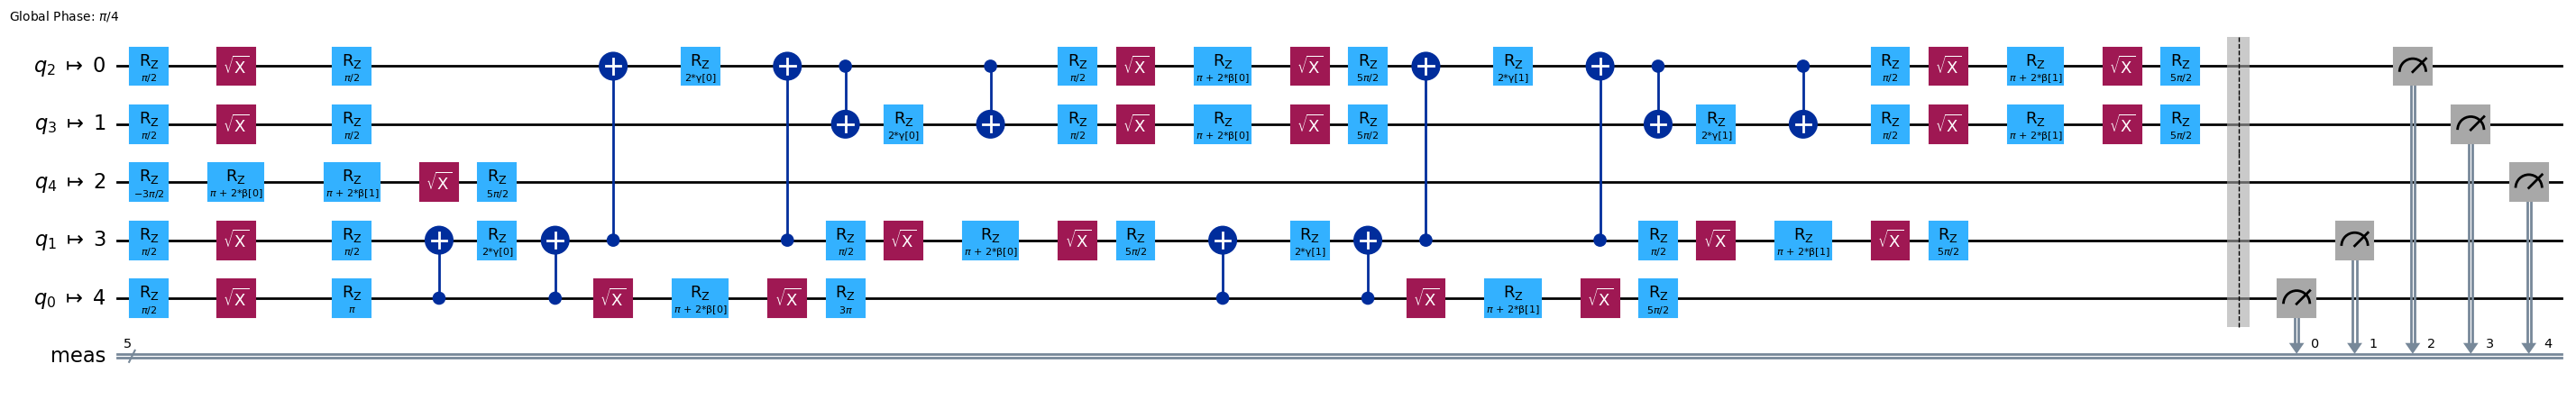

In [38]:
# Create pass manager for transpilation

pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend, seed_transpiler=seed
)

qaoa_circuit_transpiled = pm.run(qaoa_circuit)
qaoa_circuit_transpiled.draw("mpl", fold=False, idle_wires=False)


In [39]:
init_params = np.zeros(2 * layers)

In [40]:
objective_func_vals = []


def cost_func_estimator(
    params: list, ansatz: QuantumCircuit, isa_hamiltonian: SparsePauliOp, estimator: Estimator
) -> float:
    """Compute the cost function value using a parameterized ansatz and an estimator for a given Hamiltonian."""
    if isa_hamiltonian.num_qubits != ansatz.num_qubits:
        isa_hamiltonian = isa_hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost


def train_qaoa(
    params: list,
    circuit: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    backend: QiskitRuntimeService.backend,
) -> tuple:
    """Optimize QAOA parameters using COBYLA and an estimator on a given backend."""
    with Session(backend=backend) as session:
        options = {"simulator": {"seed_simulator": seed}}
        estimator = Estimator(mode=session, options=options)
        estimator.options.default_shots = 100000

        result = minimize(
            cost_func_estimator,
            params,
            args=(circuit, hamiltonian, estimator),
            method="COBYLA",
            options={"maxiter": 200, "rhobeg": 1, "catol": 1e-3, "tol": 0.0001},
        )
    print(result)
    return result, objective_func_vals


result_qaoa, objective_func_vals = train_qaoa(
    init_params, qaoa_circuit_transpiled, cost_hamiltonian, generic_backend
)


 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.8543414565854341
       x: [ 1.070e+00  1.250e+00  4.385e-01  8.672e-01]
    nfev: 65
   maxcv: 0.0


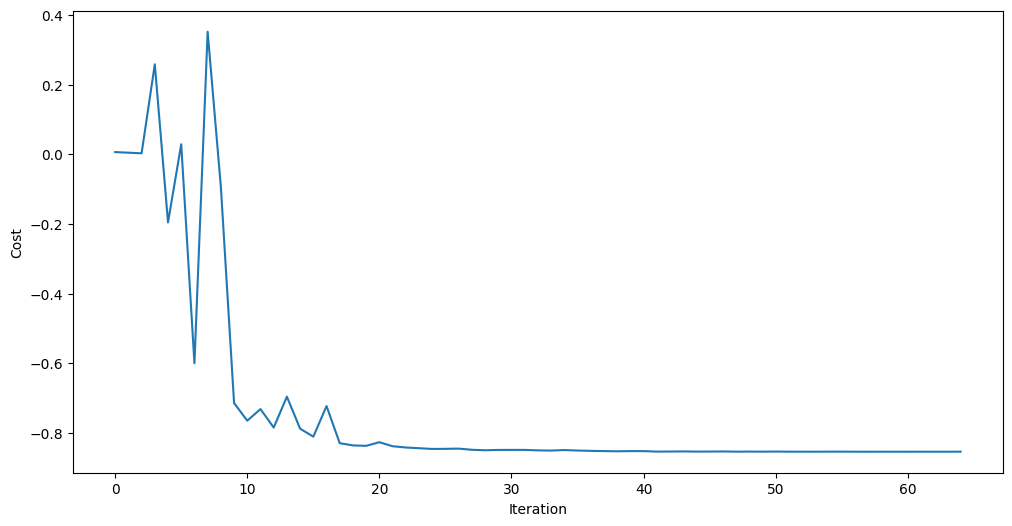

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()



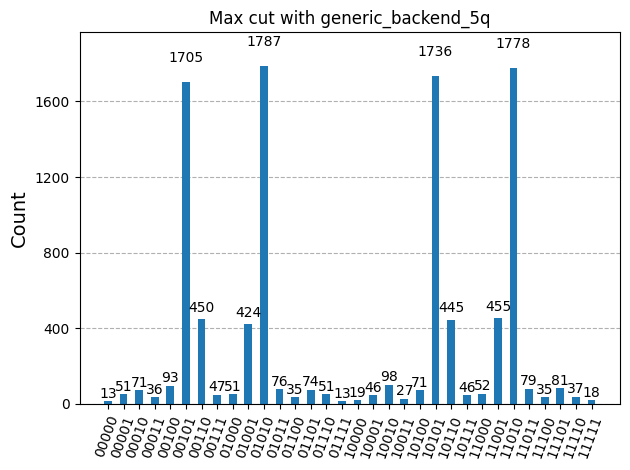

In [42]:
# Get the optimized parameters from the result
opt_params = result_qaoa.x
SHOTS = 10000


def sample_qaoa(opt_params, circuit, backend):

    # Submit the circuit to Sampler
    options = {"simulator": {"seed_simulator": seed}}
    sampler = Sampler(mode=backend, options=options)
    job = sampler.run([(circuit, opt_params)], shots=SHOTS)
    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    display(plot_histogram(counts_list, title=f"Max cut with {backend.name}"))

    return counts_list


counts_list = sample_qaoa(opt_params, qaoa_circuit_transpiled, generic_backend)


In [43]:
eigenvalues, eigenvectors = np.linalg.eig(cost_hamiltonian)
ground_energy = min(eigenvalues).real
num_solutions = eigenvalues.tolist().count(ground_energy)
index_solutions = np.where(eigenvalues == ground_energy)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy}")
print(f"The number of solutions of the problem is {num_solutions}")
print(f"The list of the solutions based on their index is {index_solutions}")

The ground energy of the Hamiltonian is -3.0
The number of solutions of the problem is 4
The list of the solutions based on their index is [5, 10, 21, 26]


In [44]:
def decimal_to_binary(decimal_list, n):
    return [bin(num)[2:].zfill(n) for num in decimal_list]


# Convert the solutions to quantum states
states_solutions = decimal_to_binary(index_solutions, n)
# Sort the dictionary items by their counts in descending order
sorted_states = sorted(counts_list.items(), key=lambda item: item[1], reverse=True)
# Take the top 'num_solutions' entries
top_states = sorted_states[:num_solutions]
# Extract only the states keys from the top entries
qaoa_ground_states = sorted([state for state, count in top_states])
print(f"The analytical solutions for the Max-cut problem are: {states_solutions}")
print(f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states}")



The analytical solutions for the Max-cut problem are: ['00101', '01010', '10101', '11010']
The QAOA ground states solutions for the Max-cut are: ['00101', '01010', '10101', '11010']


In [47]:
real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")


The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


In [48]:
# backends=[service.backend("alt_brisbane"),service.backend("alt_kawasaki"),service.backend("alt_torino")]
real_backends = [
    service.backend("ibm_brisbane"),
    service.backend("ibm_sherbrooke"),
    service.backend("ibm_torino"),
]


In [49]:
noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")

The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['reset', 'ecr', 'sx', 'id', 'x', 'measure']>), AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['reset', 'ecr', 'sx', 'id', 'x', 'measure']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['reset', 'sx', 'id', 'x', 'measure', 'cz']>)]


In [58]:

def accumulated_errors(backend, circuit) -> list:
    """Compute accumulated gate and readout errors for a given circuit on a specific backend."""

    # Initializing quantities
    acc_single_qubit_error = 0
    acc_two_qubit_error = 0
    single_qubit_gate_count = 0
    two_qubit_gate_count = 0
    acc_readout_error = 0

    # Defining useful variables
    properties = backend.properties()
    
    # Robust way to get physical qubits used in the circuit
    if circuit.layout and circuit.layout.initial_layout:
        qubit_layout = list(circuit.layout.initial_layout.get_physical_bits().keys())[:n]
    else:
        qubit_layout = list(range(circuit.num_qubits))

    # Define readout error (only for qubits in qubit_layout)
    acc_readout_error = 0
    for q in qubit_layout:
        acc_readout_error += properties.readout_error(q)
    
    # Define two qubit gates for the different backends
    config = backend.configuration()
    basis_gates = config.basis_gates
    
    if "ecr" in basis_gates:
        two_qubit_gate = "ecr"
    elif "cz" in basis_gates:
        two_qubit_gate = "cz"
    elif "cx" in basis_gates:
        two_qubit_gate = "cx"
    else:
        two_qubit_gate = "cx"
    
    # Helper function to safely get physical qubit index
    def get_physical_qubit(qubit):
        """Safely get the physical qubit index from a qubit object."""
        if circuit.layout and circuit.layout.initial_layout:
            try:
                return circuit.layout.initial_layout[qubit]
            except KeyError:
                pass
        
        # Fallback: use circuit qubit index
        try:
            return circuit.qubits.index(qubit)
        except (ValueError, AttributeError):
            return None
    
    # Loop over the instructions in circuit.data
    for instruction in circuit.data:
        gate_name = instruction.operation.name
        
        # Map virtual qubits to physical qubits
        physical_qubits = []
        for q in instruction.qubits:
            physical_qubit = get_physical_qubit(q)
            if physical_qubit is not None:
                physical_qubits.append(physical_qubit)
        
        # Only proceed if we successfully mapped all qubits
        if len(physical_qubits) == len(instruction.qubits):
            # Count and add errors for one qubit gates (excluding measure)
            if len(physical_qubits) == 1 and gate_name != "measure":
                single_qubit_gate_count += 1
                try:
                    acc_single_qubit_error += properties.gate_error(gate_name, physical_qubits)
                except Exception:
                    pass
            
            # FIXED: Correct two-qubit gate error accumulation
            elif len(physical_qubits) == 2 and gate_name == two_qubit_gate:
                two_qubit_gate_count += 1
                try:
                    # The key fix: pass qubits as a list, not tuple, and in original order
                    acc_two_qubit_error += properties.gate_error(gate_name, physical_qubits)
                except Exception:
                    # If that fails, try as tuple
                    try:
                        acc_two_qubit_error += properties.gate_error(gate_name, tuple(physical_qubits))
                    except Exception:
                        # Last resort: try with reversed order
                        try:
                            acc_two_qubit_error += properties.gate_error(gate_name, physical_qubits[::-1])
                        except Exception:
                            pass

    acc_total_error = acc_two_qubit_error + acc_single_qubit_error + acc_readout_error
    results = [
        acc_total_error,
        acc_two_qubit_error,
        acc_single_qubit_error,
        acc_readout_error,
        single_qubit_gate_count,
        two_qubit_gate_count,
    ]
    return results


In [59]:
qaoa_transpiled_list = []
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:
    pm = generate_preset_pass_manager(
        backend=noisy_fake_backend,
        optimization_level=3,
        seed_transpiler=seed,
    )
    circuit = pm.run(qaoa_circuit)
    qaoa_transpiled_list.append(circuit)

    errors_and_counts = accumulated_errors(noisy_fake_backend, circuit)
    errors_and_counts_list.append(errors_and_counts)
# You can print your results to visualize if they are correct
for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")

Backend aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 12 gates: 0.052
Accumulated one-qubit error of 133 gates: 0.008
Accumulated readout error: 0.053
Accumulated total error: 0.113

Backend aer_simulator_from(ibm_sherbrooke)
Accumulated two-qubit error of 12 gates: 0.050
Accumulated one-qubit error of 104 gates: 0.009
Accumulated readout error: 0.053
Accumulated total error: 0.112

Backend aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 12 gates: 0.038
Accumulated one-qubit error of 71 gates: 0.010
Accumulated readout error: 0.045
Accumulated total error: 0.094



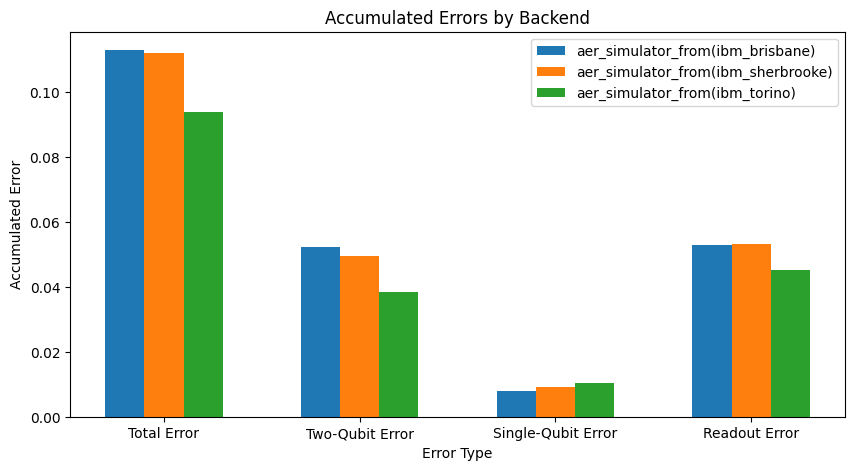

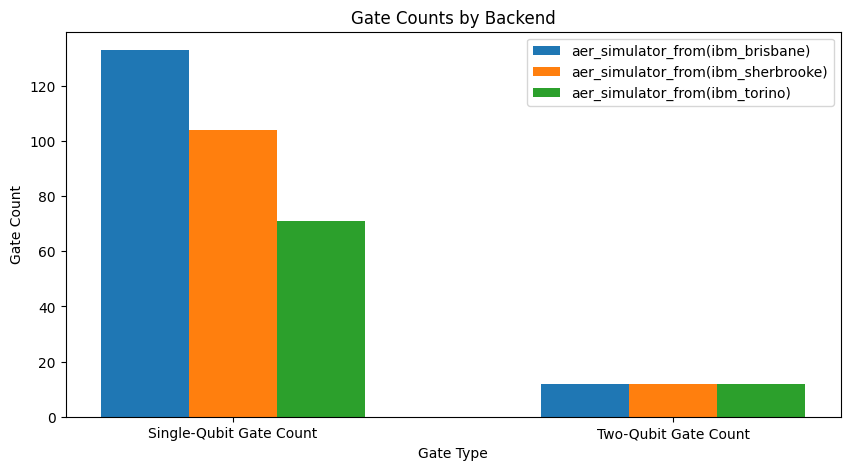

In [61]:
plot_backend_errors_and_counts(noisy_fake_backends, errors_and_counts_list)

In [62]:
grade_lab2_ex3(accumulated_errors)


Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [63]:
# We select the `ibm_brisbane` backend
num_backend = 0
noisy_fake_backend = noisy_fake_backends[num_backend]

pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed,
    layout_method="sabre",
)
circuit_transpiled = pm.run(qaoa_circuit)


def two_qubit_gate_errors_per_circuit_layout(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple:
    """Calculate accumulated two-qubit gate errors and related metrics for a given circuit layout."""
    pair_list = []
    error_pair_list = []
    error_acc_pair_list = []
    two_qubit_gate_count = 0
    properties = backend.properties()
    if "ecr" in (backend.configuration().basis_gates):
        two_qubit_gate = "ecr"
    elif "cz" in (backend.configuration().basis_gates):
        two_qubit_gate = "cz"
    for instruction in circuit.data:
        if instruction.operation.num_qubits == 2:
            two_qubit_gate_count += 1
            pair = [instruction.qubits[0]._index, instruction.qubits[1]._index]
            error_pair = properties.gate_error(gate=two_qubit_gate, qubits=pair)
            if pair not in (pair_list):
                pair_list.append(pair)
                error_pair_list.append(error_pair)
                error_acc_pair_list.append(error_pair)
            else:
                pos = pair_list.index(pair)
                error_acc_pair_list[pos] += error_pair

    acc_two_qubit_error = sum(error_acc_pair_list)
    return (
        acc_two_qubit_error,
        two_qubit_gate_count,
        pair_list,
        error_pair_list,
        error_acc_pair_list,
    )


(
    acc_two_qubit_error,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_transpiled, noisy_fake_backend)
two_qubit_ops_list = [int(a / b) for a, b in zip(error_acc_pair_list, error_pair_list)]
# We print the results
print(f"The pairs of qubits that need to perform two-qubit operations are:\n {pair_list}")
print(
    f"The errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_pair_list]}"
)
print(
    f"The accumulated errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_acc_pair_list]}"
)
print(f"The repetitions of each one of the two-qubit operations is:\n {two_qubit_ops_list}")
print(f"The number of two-qubit operations in total:\n {two_qubit_gate_count}")
print(f"The total accumulated error by two-qubit operations is:\n {acc_two_qubit_error:.3f}")

The pairs of qubits that need to perform two-qubit operations are:
 [[56, 57], [57, 58], [58, 71]]
The errors introduced by each of the two-qubit operations are:
 [0.004, 0.003, 0.005]
The accumulated errors introduced by each of the two-qubit operations are:
 [0.016, 0.014, 0.02]
The repetitions of each one of the two-qubit operations is:
 [4, 4, 4]
The number of two-qubit operations in total:
 12
The total accumulated error by two-qubit operations is:
 0.050


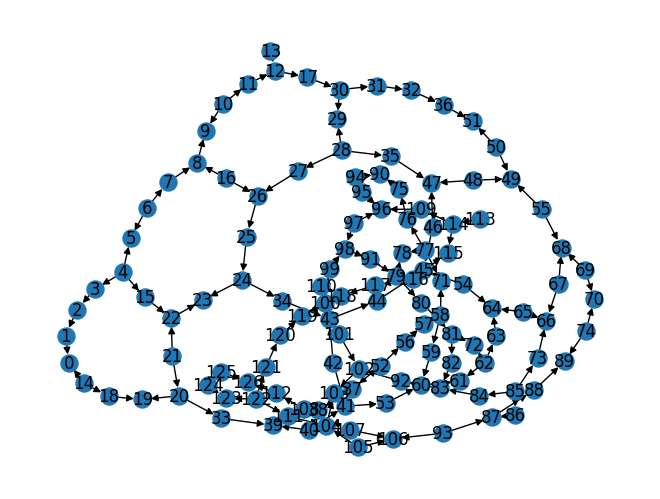

In [64]:
# We build a graph with the connectivity constraints of our backend that includes the two-qubit gate errors as weights in the edges
graph = rx.PyDiGraph()
graph.add_nodes_from(np.arange(0, noisy_fake_backend.num_qubits, 1))
two_qubit_gate = "ecr"
graph.add_edges_from(
    [
        (
            edge[0],
            edge[1],
            noisy_fake_backend.properties().gate_error(
                gate=two_qubit_gate, qubits=(edge[0], edge[1])
            ),
        )
        for edge in noisy_fake_backend.coupling_map
    ]
)
draw_graph(graph, node_size=150, with_labels=True, width=1)


In [65]:
def remap_nodes(original_labels: list, edge_list: list[list]) -> list[list[int]]:
    """Remap node labels to a new sequence starting from 0 based on their order in original_labels."""
    label_mapping = {label: idx for idx, label in enumerate(original_labels)}
    remapped = [[label_mapping[src], label_mapping[dst]] for src, dst in edge_list]
    return remapped


layout_list = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:5]
logical_pair_list = remap_nodes(layout_list, pair_list)
print(f"Physical qubit layout list:\n {layout_list}")
print(f"\nOriginal two-qubit gates list:\n {pair_list}")
print(f"\nRemapped two-qubit gates list (in logical qubits):\n {logical_pair_list}")


Physical qubit layout list:
 [56, 57, 58, 71, 85]

Original two-qubit gates list:
 [[56, 57], [57, 58], [58, 71]]

Remapped two-qubit gates list (in logical qubits):
 [[0, 1], [1, 2], [2, 3]]


In [67]:
def find_paths_with_weight_sum_below_threshold(
    graph: rx.PyDiGraph,
    threshold: float,
    two_qubit_ops_list: list[int],
    logical_pair_list: list[list[int]],
) -> tuple[list[list[int]], list[float]]:
    """Find all valid paths through a graph whose weighted sum is below a given threshold."""
    valid_paths = []
    valid_weights = []

    # Task 4 ---
    # Goal: Find all valid paths through a graph such that the total weighted sum of the path is below a given threshold.

    # Iterate over all possible starting nodes in the graph
    for start_node in range(graph.num_nodes()):
        # Initialize the list of paths with a single-node path starting from the current node
        paths = [[start_node]]
        # Initialize the corresponding weights for each path (starting with 0)
        weights = [0]
        # Iterate through each step in the sequence of two-qubit operations
        for i in range(len(two_qubit_ops_list)):
            new_paths = []    
            new_weights = []  
            # Go through each current path and its weight
            for path, weight in zip(paths, weights):
                # We need to determine which node in the current path is involved in the next logical operation, so we can expand from it.
                # Determine which node in the path we are going to expand from using logical_pair_list
                if logical_pair_list[i][0] < logical_pair_list[i][1]:
                    index_of_expanding_node = logical_pair_list[i][0] # control qubit
                    node_to_expand_from = path[index_of_expanding_node]
                    # Explore all neighbors of the node_to_expand_from
                    for neighbor in graph.neighbors(node_to_expand_from):
                        # Ensure we don't revisit nodes and the edge exists
                        if neighbor not in path and graph.has_edge(node_to_expand_from, neighbor):
                            # Calculate the edge weight, scaled by the number of times the gate is applied which is in two_qubit_ops_list
                            edge_weight = graph.get_edge_data(node_to_expand_from, neighbor) * two_qubit_ops_list[i]
                            # Extend the path and update the weight
                            new_paths.append(path + [neighbor])
                            new_weights.append(weight + edge_weight)
                else:
                    index_of_expanding_node = logical_pair_list[i][1] # target qubit
                    node_to_expand_from = path[index_of_expanding_node]
                    # Explore all undirected_neighbors of the node_to_expand_from
                    for neighbor in graph.neighbors_undirected(node_to_expand_from):
                        # Ensure we don't revisit nodes and the edge exists
                        if neighbor not in path and graph.has_edge(neighbor, node_to_expand_from):
                            # Calculate the edge weight, scaled by the number of times the gate is applied which is in two_qubit_ops_list
                            edge_weight = graph.get_edge_data(neighbor, node_to_expand_from) * two_qubit_ops_list[i]
                            # Extend the path and update the weight
                            new_paths.append(path + [neighbor])
                            new_weights.append(weight + edge_weight)
            # Update paths and weights for the next iteration
            paths = new_paths
            weights = new_weights

        # After building all possible paths, filter those under the threshold
        for path, weight in zip(paths, weights):
            if weight < threshold and len(path) == len(set(path)):  # Ensure no duplicate nodes and weight below threshold
                valid_paths.append(path)
                valid_weights.append(weight)
            
    # --- End of TODO ---

    return valid_paths, valid_weights


threshold = acc_two_qubit_error

valid_paths, valid_weights = find_paths_with_weight_sum_below_threshold(
    graph, threshold, two_qubit_ops_list, logical_pair_list
)
# Note that there could be no other paths with smaller errors
if valid_weights:
    minimum_weight_index = valid_weights.index(min(valid_weights))
    opt_layout = valid_paths[minimum_weight_index]
else:
    minimum_weight_index = None
    opt_layout = layout_list
print(f"We found {len(valid_paths)} valid paths")


We found 4 valid paths


In [69]:
grade_lab2_ex4(find_paths_with_weight_sum_below_threshold)


Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [70]:
def finding_best_seed(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple[QuantumCircuit, int, float, int]:
    """Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend."""

    # We initialize the minimum error accumulated
    min_err_acc_seed_loop = 100
    circuit_opt_best_seed = None
    best_seed_transpiler = None
    two_qubit_gate_count_seed_loop = None
    
    # First we loop over 500 seeds and transpile the circuit
    for seed_transpiler in range(0, 500):
        pm = generate_preset_pass_manager(
            backend=backend,
            optimization_level=3,
            seed_transpiler=seed_transpiler,
            layout_method="sabre",
        )
        circuit_opt_seed = pm.run([circuit])[0]
        
        # ---- TODO : Task 5 ---
        # Goal: Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend looping from 0 to 500

        # TODO Use the `two_qubit_gate_errors_per_circuit_layout` function to count for the error of the transpile circuit
        (
            acc_two_qubit_error,
            two_qubit_gate_count,
            _,
            _,
            _,
        ) = two_qubit_gate_errors_per_circuit_layout(circuit_opt_seed, backend)

        # TODO Check if the error accounted above is smaller than min_err_acc_seed_loop. If so, assign the variables that this function returns
        if acc_two_qubit_error < min_err_acc_seed_loop:
            min_err_acc_seed_loop = acc_two_qubit_error
            circuit_opt_best_seed = circuit_opt_seed
            best_seed_transpiler = seed_transpiler
            two_qubit_gate_count_seed_loop = two_qubit_gate_count

        # --- End of TODO ---

    return (
        circuit_opt_best_seed,
        best_seed_transpiler,
        min_err_acc_seed_loop,
        two_qubit_gate_count_seed_loop,
    )


In [71]:
(
    circuit_opt_seed_loop,
    best_seed_transpiler,
    min_err_acc_seed_loop,
    two_qubit_gate_count_seed_loop,
) = finding_best_seed(qaoa_circuit, noisy_fake_backend)

best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:n]
print(f"Best transpiler seed: {best_seed_transpiler}")
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed_loop:.3f}")
print(f"Two-qubit gate count for best seed: {two_qubit_gate_count_seed_loop}")
print(f"Best layout (first n logical qubits mapped to physical qubits):\n {best_layout}")


Best transpiler seed: 215
Minimum accumulated two-qubit gate error: 0.040
Two-qubit gate count for best seed: 12
Best layout (first n logical qubits mapped to physical qubits):
 [2, 3, 4, 15, 119]


In [72]:
grade_lab2_ex5(finding_best_seed)


Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.023269767302327
       x: [ 1.307e+00  3.191e-01  6.456e-01  1.905e+00]
    nfev: 98
   maxcv: 0.0


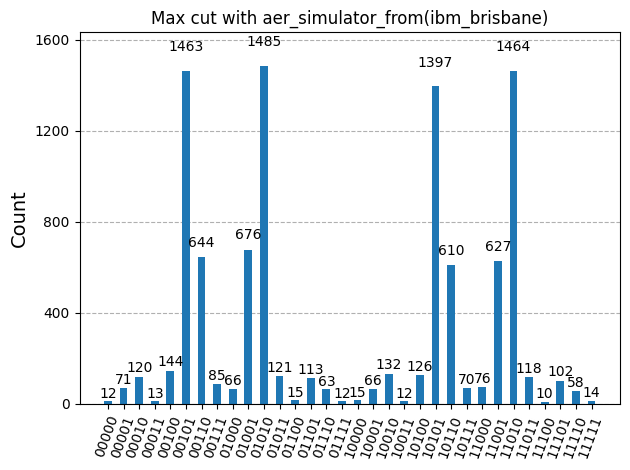

Probability of measuring a solution for is 0.5809
 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -1.9301906980930192
       x: [ 1.285e+00  3.667e-01  7.239e-01  1.807e+00]
    nfev: 75
   maxcv: 0.0


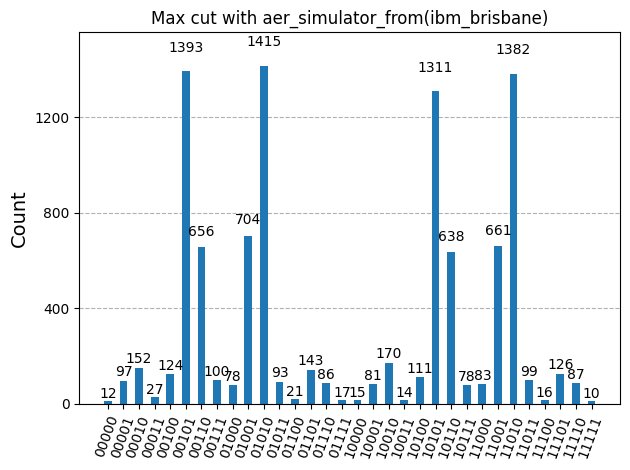

Probability of measuring a solution for is 0.5501


In [73]:
counts_list_transpiled_circuits = []
circuit_transpiled_list = [circuit_transpiled, circuit_opt_seed_loop]
opt_params_list_transpiled_circuits = []
for circuit in circuit_transpiled_list:
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list_transpiled_circuits.append(opt_params)
    counts_list_transpiled_circuit = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_transpiled_circuits.append(counts_list_transpiled_circuits)
    solutions_counts = [counts_list_transpiled_circuit[key] for key in states_solutions]
    print(f"Probability of measuring a solution for is {float(sum(solutions_counts)/SHOTS)}")

In [75]:
def fold_global_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Apply global circuit folding for Zero Noise Extrapolation (ZNE)."""
    if scale_factor % 2 == 0 or scale_factor < 1:
        raise ValueError("scale_factor must be an odd positive integer (1, 3, 5, ...)")
    # We define the number of times we are going to "fold" the circuit
    n_repeat = (scale_factor - 1) // 2
    folded_circuit = QuantumCircuit(circuit.qubits, circuit.clbits)

    def remove_all_measurements(qc: QuantumCircuit) -> QuantumCircuit:
        """Remove all measurements from a quantum circuit."""
        clean_qc = QuantumCircuit(qc.num_qubits)
        for instr in qc.data:
            if instr.operation.name != "measure":
                clean_qc.append(instr.operation, instr.qubits)
        return clean_qc

    # Make a quantum circuit as a U (Unitary) by removing measurements, since measurements are not unitary
    clean_circuit = remove_all_measurements(circuit)

    # ---- TODO : Task 6a ---
    # Implement the global circuit folding. Use `QuantumCircuit.append` and `QuantumCircuit.inverse` functions
    # add U^† (inverse of clean_circuit) then U(clean_circuit) to the main circuit (folded_circuit)
    folded_circuit.append(clean_circuit, folded_circuit.qubits)
    for _ in range(n_repeat):
        folded_circuit.append(clean_circuit.inverse(), folded_circuit.qubits)
        folded_circuit.append(clean_circuit, folded_circuit.qubits)
    # --- End of TODO --

    return folded_circuit


In [76]:
grade_lab2_ex6a(fold_global_circuit)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [81]:
def fold_local_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Performs Zero-Noise Folding at the level of individual circuit instructions."""

    if scale_factor % 2 == 0:
        raise ValueError("scale must be an odd positive integer (1, 3, 5, ...)")
    # We define the number of times we are going to "fold" each instruction
    n_repeat = (scale_factor - 1) // 2
    qc_folded = QuantumCircuit(circuit.qubits, circuit.clbits)

    if scale_factor == 1:
        return circuit
    else:
        for instruction in circuit.data:
            # ---- TODO : Task 6b ---
            # Implement the local circuit folding. Don't fold measurement gates!
            if instruction.operation.name != "measure":
                qc_folded.append(instruction.operation, instruction.qubits)
                for _ in range(n_repeat):
                    qc_folded.append(instruction.operation.inverse(), instruction.qubits)
                    qc_folded.append(instruction.operation, instruction.qubits)
            else:
                qc_folded.append(instruction.operation, instruction.qubits, instruction.clbits)
            # --- End of TODO ---

    return qc_folded


grade_lab2_ex6b(fold_local_circuit)


Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [82]:
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 2/2 exercises completed (100%)
    ✅ 1863 participants have completed this lab
Lab 1: 9/9 exercises completed (100%)
    ✅ 1166 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 419 participants have completed this lab
Lab 3: 0/5 exercises completed (0%)
    ✅ 1 participants have completed this lab
Lab 4: 0/6 exercises completed (0%)
    ✅ 0 participants have completed this lab
Functions Labs: 0/8 exercises completed (0%)
    ✅ 0 participants have completed this lab
